- <a href="#acute_or_chronic">acute_or_chronic</a><br>
- <a href="#diagnoses">diagnosis</a><br>
- <a href="#labs">Labs</a><br>
- <a href="#pacemaker">pacemaker</a><br>
- <a href="#duration">duration</a><br>
- <a href="#"></a><br>

Load the data frame for EDA using %load Pipeline_clean.py

In [7]:
# %load Pipeline_clean.py
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from data_merge import *
from Clean_Fun import *
from dtypeFun import *
from Meta_fun import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from featureEDAfun import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
df=pd.read_csv('Data/after_merge.csv',index_col=0)

In [38]:
df=meta_clean(df)

EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
EF less than 0 set to None
Couldn't extract EF so set to na_val
51 (30 -35)
Imputing 121.0,242.0 from other column
Imputing 90.0,180.0 from other column
Imputing 134,80 from Blood Pressure Column
Imputing 116,73 from Blood Pressure Column
Imputing 134,80 from Blood Pressure Column
Imputing 116,73 from Blood Pressure Column
num missing 383
value counts before zero and one assignment: 0                                                       383
lisinopril 5mg qd                                        41
none                                                     35
lisinopril 2.5mg qd                                      34
losartan 50mg qd                                         21
lisinopril 10mg qd                                       20
losartan 10

removing invalid row: 0

patient_link                             n0EPhlbX
enrollId                               n0EPhlbX_3
Enrollment_Date                               NaN
name                                 1 Tester, Mv
create_user        notifications@providerloop.com
Name: 0, dtype: object
--------------------------------------------------

 
 Dropped 1 rows from the dataset
New size of dataset: (763, 54)
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcome to 2 for patients that have been discharged but we don't have a status on them
Setting outcom

/usr/lib/python3.7/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## impute missing

In [39]:
final_imputation(df)

Successfully imputed for all missing values


### Numeric features

## ef

Summary Stats:
----------------------------------------
count    760.000000
mean       0.486566
std        0.131954
min        0.100000
25%        0.425000
50%        0.500000
75%        0.560000
max        0.820000
Name: ef, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
335    0.100
6      0.100
23     0.125
240    0.125
698    0.140
191    0.150
534    0.150
629    0.150
365    0.165
24     0.170
Name: ef, dtype: float64
Max 10 values:
----------------------------------------
582    0.7000
741    0.7100
686    0.7500
39     0.7500
271    0.7500
20     0.7750
331    0.7800
153    0.8000
235    0.8002
416    0.8200
Name: ef, dtype: float64
Histogram:
----------------------------------------


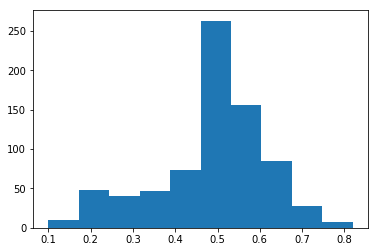

In [7]:
numericFeatureAnalysis(df, "ef")

### admit_weight

In [8]:
numericFeatureAnalysis(df, "admit_weight")

Summary Stats:
----------------------------------------


KeyError: 'admit_weight'

Skew. A lot of missing. Impute current weight if available?

### weight

No missing weight numbers, seems like a good way to impute.

Log plot is better, but still a bit skew.

### weight

Summary Stats:
----------------------------------------
count    760.000000
mean     170.278763
std       57.530758
min       71.200000
25%      132.075000
50%      158.000000
75%      195.325000
max      468.000000
Name: weight, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
738    71.20
144    72.00
239    73.00
351    75.80
690    76.60
706    79.20
606    80.20
480    80.52
393    82.00
346    86.00
Name: weight, dtype: float64
Max 10 values:
----------------------------------------
336    340.1
614    344.0
623    374.8
34     378.8
681    386.0
582    390.5
720    401.2
324    410.0
609    432.0
436    468.0
Name: weight, dtype: float64
Histogram:
----------------------------------------


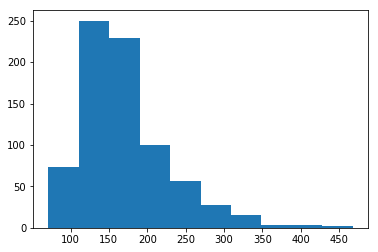

In [9]:
numericFeatureAnalysis(df, "weight")

Skew.

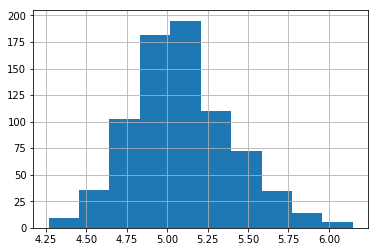

In [10]:
(df.weight).map(np.log).hist()

Better, still a bit skew.

### this_weight_change

Summary Stats:
----------------------------------------
count    760.000000
mean      -0.002785
std        0.029661
min       -0.240781
25%       -0.009533
50%        0.000000
75%        0.006184
max        0.170732
Name: this_weight_change_frac, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
210   -0.240781
736   -0.195455
746   -0.159492
516   -0.140777
286   -0.140244
480   -0.127670
483   -0.117117
325   -0.116466
136   -0.108871
436   -0.108120
Name: this_weight_change_frac, dtype: float64
Max 10 values:
----------------------------------------
755    0.070085
107    0.071429
64     0.073421
320    0.085455
46     0.089674
711    0.102510
386    0.120536
375    0.148021
400    0.159322
660    0.170732
Name: this_weight_change_frac, dtype: float64
Histogram:
----------------------------------------


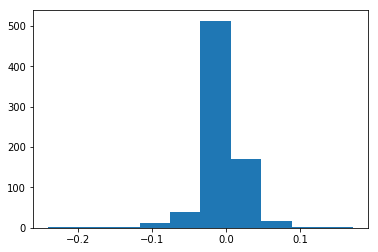

In [17]:
numericFeatureAnalysis(df, "this_weight_change_frac")

### weight_change_since_admit

Summary Stats:
----------------------------------------
count    760.000000
mean       0.003350
std        0.075464
min       -0.247216
25%        0.000000
50%        0.000000
75%        0.003004
max        0.241877
Name: weight_change_since_admit_frac, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
27    -0.247216
219   -0.242647
64    -0.240822
12    -0.232123
270   -0.223881
346   -0.220930
665   -0.220708
11    -0.213434
53    -0.212121
718   -0.207143
Name: weight_change_since_admit_frac, dtype: float64
Max 10 values:
----------------------------------------
195    0.209828
608    0.213811
148    0.214072
592    0.216418
450    0.221184
678    0.227941
563    0.229015
622    0.232643
28     0.233333
13     0.241877
Name: weight_change_since_admit_frac, dtype: float64
Histogram:
----------------------------------------


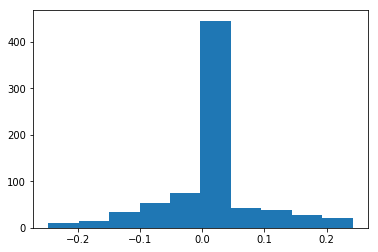

In [19]:
numericFeatureAnalysis(df, "weight_change_since_admit_frac")

Hist looks OK. Impute missing as 0 or by weight change since last measurement?

<p><a name="labs"></a></p>
## Labs

<p><a name="bnp"></a></p>
### BNP

Summary Stats:
----------------------------------------
count      760.000000
mean       676.247342
std       2714.392657
min          1.990000
25%         74.750000
50%        228.500000
75%        578.250000
max      68432.000000
Name: bnp, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
152    1.99
206    1.99
474    2.00
151    2.00
715    2.00
35     2.00
700    2.00
146    2.00
10     2.00
640    6.00
Name: bnp, dtype: float64
Max 10 values:
----------------------------------------
286     5000.0
24      5000.0
599     5000.0
409     5000.0
684     5000.0
287     5000.0
387     5000.0
16      5000.0
207    19085.0
15     68432.0
Name: bnp, dtype: float64
Histogram:
----------------------------------------


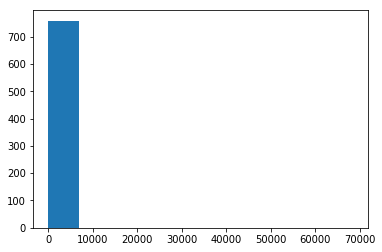

In [20]:
numericFeatureAnalysis(df, "bnp")

Heavily skewed plot! Are values greater than 5000 outliers/typos?

(array([  9.,  13.,  23.,  78., 115., 134., 167., 113.,  57.,  49.]),
 array([0.68813464, 1.47104049, 2.25394635, 3.0368522 , 3.81975806,
        4.60266392, 5.38556977, 6.16847563, 6.95138148, 7.73428734,
        8.51719319]),
 <a list of 10 Patch objects>)

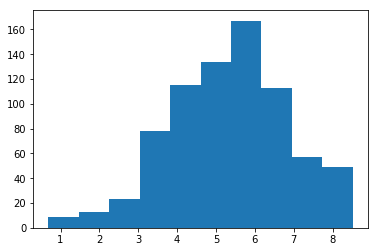

In [21]:
plt.hist(df.bnp[df.bnp < 5001].map(np.log))

log plot is much better! Box-Cox?

### this_bnp_change

Summary Stats:
----------------------------------------
count     760.000000
mean        6.515816
std       387.976491
min     -2966.000000
25%       -35.000000
50%         0.000000
75%        46.000000
max      2580.000000
Name: this_bnp_change, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
207   -2966.0
93    -2600.0
259   -1848.0
301   -1780.0
549   -1774.0
584   -1725.0
59    -1699.0
41    -1549.0
202   -1419.0
136   -1165.0
Name: this_bnp_change, dtype: float64
Max 10 values:
----------------------------------------
377    1304.0
249    1433.0
660    1439.0
221    1480.0
568    1510.0
478    1556.0
588    1704.0
673    1816.0
676    2393.0
94     2580.0
Name: this_bnp_change, dtype: float64
Histogram:
----------------------------------------


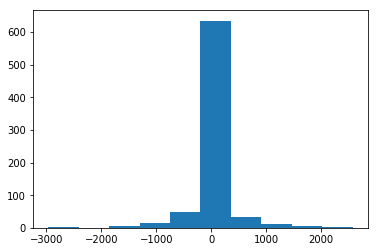

In [22]:
numericFeatureAnalysis(df, "this_bnp_change")

Few missing. Suggest imputing 0? Perhaps they only have one bnp measurement.

-66618 bnp change is a ludicrous outlier

2580 is an outlier, but perhaps not rediculous.

(array([  6.,   2.,  14.,  19., 187., 338.,  26.,  14.,   6.,   5.]),
 array([-1848. , -1481.6, -1115.2,  -748.8,  -382.4,   -16. ,   350.4,
          716.8,  1083.2,  1449.6,  1816. ]),
 <a list of 10 Patch objects>)

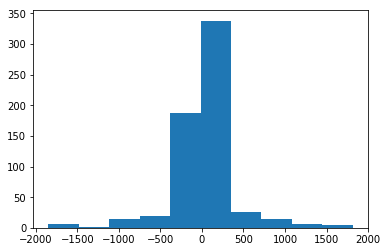

In [23]:
plt.hist(df.this_bnp_change.dropna()[(df.this_bnp_change > -2000)&(df.this_bnp_change != 0)&(df.this_bnp_change < 2000)])

## Labs

### bun

Summary Stats:
----------------------------------------
count    760.000000
mean      34.096053
std       21.231579
min        8.000000
25%       19.000000
50%       28.000000
75%       43.000000
max      205.000000
Name: bun, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
284     8.0
228     9.0
324     9.0
441     9.0
648     9.0
609     9.0
607     9.0
666     9.0
282     9.0
349    10.0
Name: bun, dtype: float64
Max 10 values:
----------------------------------------
101     99.0
436     99.0
617    100.0
482    102.0
479    105.0
234    106.0
382    109.0
165    125.0
555    128.0
404    205.0
Name: bun, dtype: float64
Histogram:
----------------------------------------


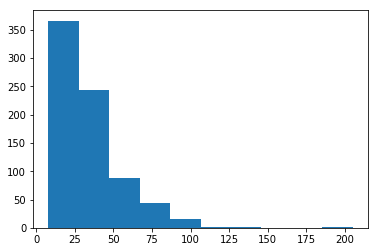

In [24]:
numericFeatureAnalysis(df, "bun")

Impute single missing with mean?

max value outlier?

Skew Hist.

Why the 0 values? If imputed, I suggest changing the imputation to be the average.

(array([ 32.,  59., 159., 156., 143., 107.,  64.,  36.,   3.,   1.]),
 array([2.07944154, 2.40379839, 2.72815523, 3.05251207, 3.37686892,
        3.70122576, 4.0255826 , 4.34993945, 4.67429629, 4.99865314,
        5.32300998]),
 <a list of 10 Patch objects>)

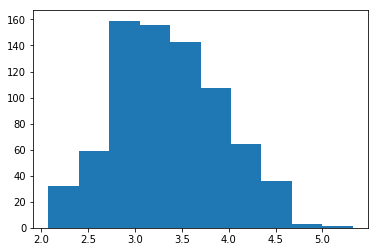

In [25]:
plt.hist((df.bun[df.bun > 0]).map(np.log))

Log plot is better. Box-Cox?

### cr

Summary Stats:
----------------------------------------
count    760.000000
mean       1.549961
std        1.361379
min        0.200000
25%        0.800000
50%        1.100000
75%        1.600000
max        9.100000
Name: cr, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
677    0.2
276    0.3
474    0.3
164    0.3
690    0.3
400    0.3
250    0.4
256    0.4
500    0.4
532    0.4
Name: cr, dtype: float64
Max 10 values:
----------------------------------------
409    7.10
410    7.80
599    7.92
596    8.13
639    8.24
7      8.30
27     8.40
663    8.80
404    8.90
508    9.10
Name: cr, dtype: float64
Histogram:
----------------------------------------


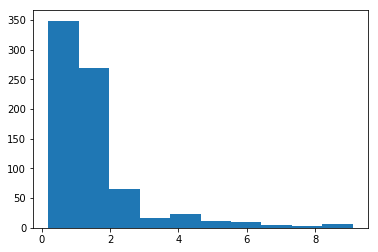

In [26]:
numericFeatureAnalysis(df, "cr")

Impute missing using mean?

Nonsensical zero values? Treat as missing?

Skew plot!

(array([  1.,  15.,  65., 194., 219., 125.,  66.,  30.,  29.,  16.]),
 array([-1.60943791, -1.22766668, -0.84589545, -0.46412421, -0.08235298,
         0.29941825,  0.68118948,  1.06296072,  1.44473195,  1.82650318,
         2.20827441]),
 <a list of 10 Patch objects>)

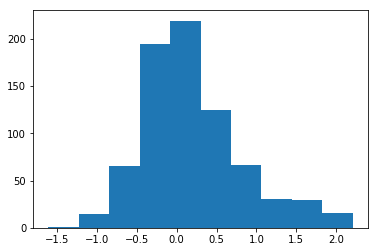

In [27]:
plt.hist((df.cr[df.cr > 0]).map(np.log))

Log plot is better but still seems a bit skewed. Box-Cox?

### sodium

Summary Stats:
----------------------------------------
count    430.000000
mean     140.386047
std        4.170581
min      120.000000
25%      138.000000
50%      141.000000
75%      143.000000
max      164.000000
Name: sodium, dtype: float64
Number of missing values:
----------------------------------------
330
Min 10 values:
----------------------------------------
85     120.0
81     126.0
149    127.0
734    130.0
24     130.0
75     131.0
220    131.0
109    132.0
71     132.0
676    132.0
Name: sodium, dtype: float64
Max 10 values:
----------------------------------------
741    149.0
20     149.0
509    150.0
5      150.0
243    151.0
692    151.0
33     152.0
16     153.0
116    156.0
165    164.0
Name: sodium, dtype: float64
Histogram:
----------------------------------------


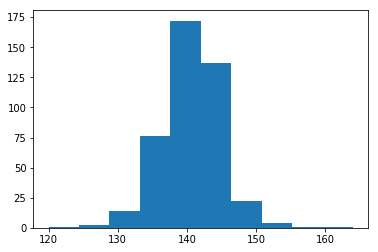

In [29]:
numericFeatureAnalysis(df, "sodium")

Loads of missing! How to impute?

Not bad.

### potasium

Summary Stats:
----------------------------------------
count    760.000000
mean       4.419605
std        0.604134
min        2.000000
25%        4.000000
50%        4.400000
75%        4.800000
max        7.500000
Name: potasium, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
617    2.0
684    2.4
39     2.7
692    2.8
418    3.0
710    3.0
503    3.0
688    3.0
123    3.1
744    3.2
Name: potasium, dtype: float64
Max 10 values:
----------------------------------------
697    5.8
14     5.9
673    5.9
675    5.9
387    5.9
325    5.9
219    6.0
599    6.2
56     7.3
650    7.5
Name: potasium, dtype: float64
Histogram:
----------------------------------------


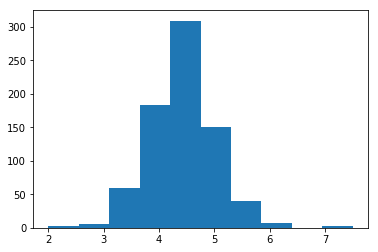

In [35]:
numericFeatureAnalysis(df, "potasium")

Impute missing value with mean?

Are 0 values Errors? Treat as missing?

22.3 L value seems like crazy outlier? Treat as 2.3? Treat as missing?

(array([  2.,   6.,  60., 183., 309., 151.,  40.,   7.,   0.,   2.]),
 array([2.  , 2.55, 3.1 , 3.65, 4.2 , 4.75, 5.3 , 5.85, 6.4 , 6.95, 7.5 ]),
 <a list of 10 Patch objects>)

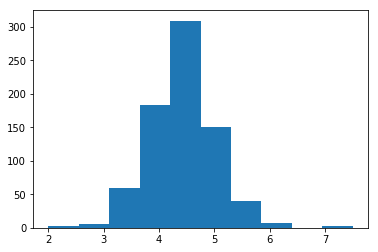

In [36]:
plt.hist(df.potasium[(df.potasium < 20)&(df.potasium > 0)].dropna())

Looks OK with 0 and outlier removed.

### mg

Summary Stats:
----------------------------------------
count    664.000000
mean       2.146175
std        0.533624
min        0.400000
25%        1.800000
50%        2.100000
75%        2.300000
max        4.900000
Name: mg, dtype: float64
Number of missing values:
----------------------------------------
96
Min 10 values:
----------------------------------------
296    0.4
269    1.0
318    1.1
736    1.1
455    1.1
400    1.1
348    1.1
667    1.1
284    1.2
62     1.2
Name: mg, dtype: float64
Max 10 values:
----------------------------------------
384    4.0
44     4.0
385    4.0
127    4.0
18     4.1
502    4.1
40     4.1
471    4.1
705    4.2
755    4.9
Name: mg, dtype: float64
Histogram:
----------------------------------------


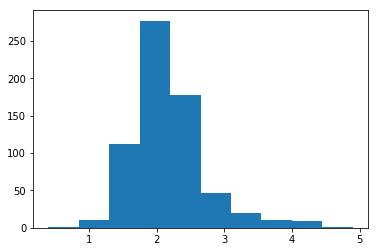

In [38]:
numericFeatureAnalysis(df, "mg")

A lot of missing!

Not a bad plot

Are these 0 values errors? Change to mean? There's a lot of missing already...

### this_cr_change

Summary Stats:
----------------------------------------
count    760.000000
mean       1.544026
std       27.545234
min     -300.000000
25%       -8.000000
50%        0.000000
75%       12.500000
max      100.000000
Name: this_cr_change, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
690   -300.00
170   -133.33
298   -127.27
744   -111.11
276   -100.00
202    -93.33
672    -88.89
317    -80.00
123    -75.00
273    -70.00
Name: this_cr_change, dtype: float64
Max 10 values:
----------------------------------------
341    100.0
414    100.0
229    100.0
430    100.0
104    100.0
584    100.0
161    100.0
539    100.0
30     100.0
100    100.0
Name: this_cr_change, dtype: float64
Histogram:
----------------------------------------


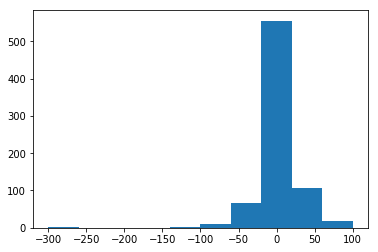

In [39]:
numericFeatureAnalysis(df, "this_cr_change")

Significant missing values. Is there only a single cr measurement? If so impute 0?

-300 looks like outlier. Treat as missing?

Hist Looks OK.

### resting_hr

Summary Stats:
----------------------------------------
count    760.000000
mean      76.690789
std       11.463084
min       38.000000
25%       70.000000
50%       76.000000
75%       82.000000
max      165.000000
Name: resting_hr, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
622    38.0
688    50.0
414    51.0
237    52.0
43     52.0
337    54.0
695    54.0
442    54.0
445    55.0
402    55.0
Name: resting_hr, dtype: float64
Max 10 values:
----------------------------------------
134    110.0
476    111.0
103    112.0
484    112.0
571    112.0
92     115.0
58     120.0
666    120.0
41     127.0
44     165.0
Name: resting_hr, dtype: float64
Histogram:
----------------------------------------


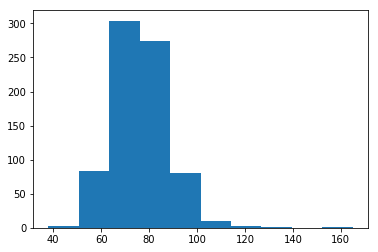

In [40]:
numericFeatureAnalysis(df, "resting_hr")

Impute missing with mean?

### systolic

Summary Stats:
----------------------------------------
count    760.000000
mean     128.631579
std       19.954191
min       49.000000
25%      116.000000
50%      127.000000
75%      140.000000
max      201.000000
Name: systolic, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
590    49.0
304    60.0
219    73.0
416    78.0
337    80.0
392    82.0
41     82.0
305    84.0
361    85.0
411    85.0
Name: systolic, dtype: float64
Max 10 values:
----------------------------------------
233    178.0
163    179.0
104    179.0
580    185.0
561    187.0
503    187.0
697    192.0
57     193.0
109    197.0
50     201.0
Name: systolic, dtype: float64
Histogram:
----------------------------------------


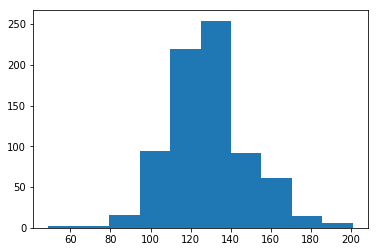

In [19]:
numericFeatureAnalysis(df, "systolic")

Impute missing with mean?

Min value of 18 looks like an outlier.

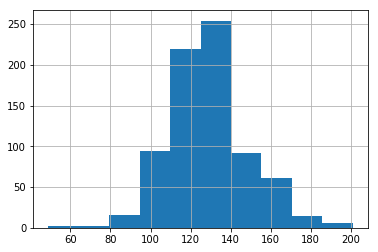

In [20]:
df.systolic[df.systolic > 18].hist()

### diastolic

Summary Stats:
----------------------------------------
count    760.000000
mean      71.177632
std       12.582325
min       42.000000
25%       64.000000
50%       70.000000
75%       78.000000
max      242.000000
Name: diastolic, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
46     42.0
146    42.0
425    43.0
498    44.0
475    45.0
359    45.0
149    48.0
396    49.0
537    49.0
501    50.0
Name: diastolic, dtype: float64
Max 10 values:
----------------------------------------
408     98.0
675     99.0
666     99.0
540    100.0
50     102.0
73     103.0
623    107.0
234    112.0
535    180.0
330    242.0
Name: diastolic, dtype: float64
Histogram:
----------------------------------------


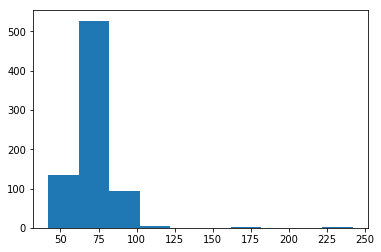

In [26]:
numericFeatureAnalysis(df, "diastolic")

Impute missing with mean?

Min value 1 is an error

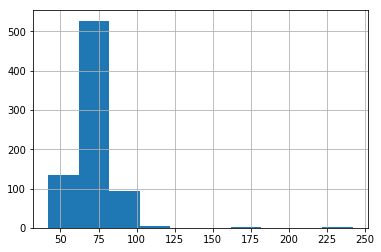

In [27]:
df.diastolic[df.diastolic > 1].hist()

Impute diastolic using systolic where possible. Function should not be too bad.

<p><a name="duration"></a></p>
## Duration

Summary Stats:
----------------------------------------
count     760.000000
mean      154.746053
std       235.275960
min         1.000000
25%        35.000000
50%        57.000000
75%       168.000000
max      2230.000000
Name: duration, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
567    1.0
758    1.0
227    1.0
580    2.0
136    3.0
425    3.0
670    3.0
407    3.0
178    4.0
94     4.0
Name: duration, dtype: float64
Max 10 values:
----------------------------------------
540    1007.0
577    1065.0
551    1106.0
636    1115.0
552    1207.0
582    1257.0
3      1276.0
485    1390.0
655    1976.0
466    2230.0
Name: duration, dtype: float64
Histogram:
----------------------------------------


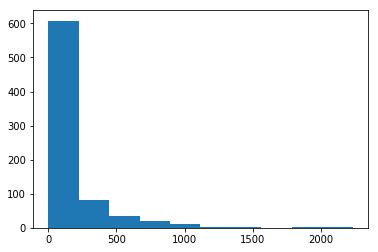

In [28]:
numericFeatureAnalysis(df, "duration")

Why all the negative durations?

20 missing durations.

In [29]:
(df.duration < 0).sum()

0

(array([608.,  82.,  34.,  19.,  11.,   3.,   1.,   0.,   1.,   1.]),
 array([1.0000e+00, 2.2390e+02, 4.4680e+02, 6.6970e+02, 8.9260e+02,
        1.1155e+03, 1.3384e+03, 1.5613e+03, 1.7842e+03, 2.0071e+03,
        2.2300e+03]),
 <a list of 10 Patch objects>)

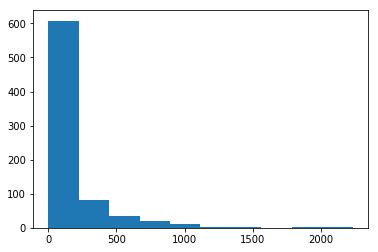

In [30]:
plt.hist(df.duration[(df.duration > -1 )])

Plot is heavily skewed.

(array([  4.,   7.,  24.,  60., 169., 242.,  99.,  87.,  59.,   9.]),
 array([0.        , 0.77097569, 1.54195137, 2.31292706, 3.08390275,
        3.85487843, 4.62585412, 5.39682981, 6.16780549, 6.93878118,
        7.70975686]),
 <a list of 10 Patch objects>)

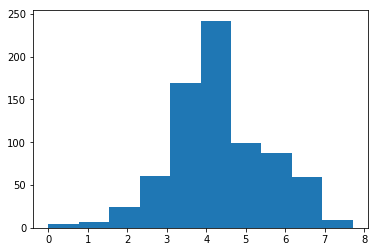

In [31]:
plt.hist(df.duration[df.duration > 0].map(np.log))

Log histogram of non-missing values looks much more normal. Box-Cox transformation may be appropriate here.

### age

Summary Stats:
----------------------------------------
count    760.000000
mean      77.670146
std       11.844926
min       38.000000
25%       70.000000
50%       78.000000
75%       87.000000
max      103.000000
Name: age, dtype: float64
Number of missing values:
----------------------------------------
0
Min 10 values:
----------------------------------------
726    38.0
284    43.0
123    45.0
323    46.0
235    46.0
324    46.0
637    48.0
489    48.0
228    48.0
609    51.0
Name: age, dtype: float64
Max 10 values:
----------------------------------------
756    100.0
150    100.0
578    100.0
735    100.0
488    100.0
580    101.0
115    101.0
641    101.0
707    102.0
653    103.0
Name: age, dtype: float64
Histogram:
----------------------------------------


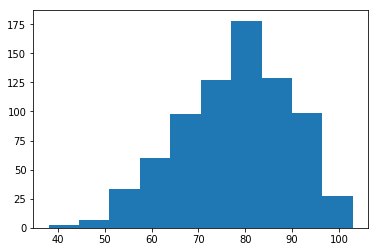

In [40]:
numericFeatureAnalysis(df, "age")

Is there a sensible way to impute age?

Are ages less than 20 reasonable? Some are negative!

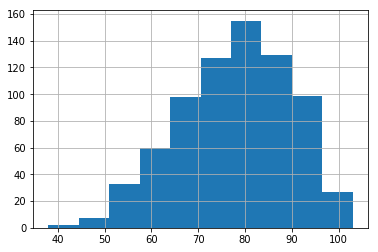

In [173]:
df.age[df.age > 20].hist()

In [175]:
df.age[df.age < 20]

13      0.0
136     0.0
168     0.0
367     1.0
404     1.0
405     1.0
442    -6.0
445   -30.0
446    -6.0
447   -12.0
454   -11.0
475   -22.0
514   -28.0
541     5.0
Name: age, dtype: float64

In [174]:
(df.age < 20).sum()

14

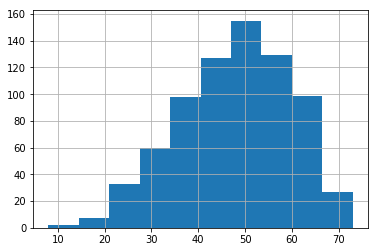

In [148]:
(df.age[df.age > 20]-30).hist()

<p><a name="diagnoses"></a></p>
## Diagnoses

In [127]:
df.columns

Index(['patient_gender', 'ef', 'admit_weight', 'acute_or_chronic', 'weight',
       'this_weight_change', 'weight_change_since_admit', 'bnp',
       'this_bnp_change', 'ace', 'bb', 'diuretics', 'anticoagulant',
       'ionotropes', 'other_cardiac_meds', 'bun', 'cr', 'potasium',
       'this_cr_change', 'resting_hr', 'systolic', 'diastolic', 'outcome',
       'cad/mi', 'heart_failure_unspecfied', 'diastolic_heart_failure',
       'systolic_chf', 'atrial_fibrilation', 'cardiomyoapthy', 'lvad', 'chf',
       'duration', 'age', 'F_5nKZ993n', 'F_71ADiKaS', 'F_Fy1r9IXM',
       'F_KYzNhByH', 'F_L1V04aB0', 'F_US4llDDz', 'F_Xxk5Yn3E', 'F_kIUZIzRp',
       'F_mB0G57bu'],
      dtype='object')

<p><a name="pacemaker"></a></p>
## Pacemaker (aicd)

In [128]:
df.aicd.value_counts(dropna = False)

AttributeError: 'DataFrame' object has no attribute 'aicd'

## Meds

### Ace

In [131]:
df.ace.value_counts(dropna = False)

0.0    268
1.0    189
Name: ace, dtype: int64

### bb

In [132]:
df.bb.value_counts(dropna = False)

1.0    326
0.0    131
Name: bb, dtype: int64

### diuretics

In [133]:
df.diuretics.value_counts(dropna = False)

1.0    295
0.0    162
Name: diuretics, dtype: int64

### anticoagulant

In [134]:
df.anticoagulant.value_counts(dropna = False)

1.0    338
0.0    119
Name: anticoagulant, dtype: int64

### ionotropes

In [135]:
df.ionotropes.value_counts(dropna = False)

0.0    417
1.0     40
Name: ionotropes, dtype: int64

### other cardiac meds

In [136]:
df.other_cardiac_meds.value_counts(dropna = False)

NaN                                                                                                                                                                    177
Atorvastatin 40mg QD                                                                                                                                                    17
Atorvastatin 80mg QD                                                                                                                                                    14
Amlodipine 5mg QD                                                                                                                                                        8
Amlodipine 10mg QD                                                                                                                                                       7
Amiodarone 200mg QD                                                                                                                              

other cardiac meds column uncleaned?